<a href="https://colab.research.google.com/github/vbrail/Chemical_compound/blob/master/vinchigcp_Pucho_technologies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import cv2
import math
import os
from PIL import Image
import split_folders
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
tf.__version__

'2.2.0-rc0'

In [0]:
from tensorflow.keras import datasets,layers,Model,optimizers,metrics
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
proj_path='/content/drive/My Drive/Colab Notebooks/pucho_technologies'
data_path='/content/drive/My Drive/Colab Notebooks/pucho_technologies/data/natural_images'

In [0]:
split_folders.ratio(data_path, output=os.path.join(proj_path,'DATA'), seed=1337, ratio=(.7, .2, .1)) 

Copying files: 6986 files [58:28,  1.99 files/s]


In [0]:
DATA_path='/content/drive/My Drive/Colab Notebooks/pucho_technologies/DATA'

In [0]:
def display(imglist):
  plt.figure(figsize=(20,25))
  no_of_img = len(imglist)
  col = 4
  row = math.ceil(no_of_img/4)
  for i in range(no_of_img):
      plt.subplot(row,col,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(plt.imread(os.path.join(data_path,imglist[i].split('_')[0]+'/'+imglist[i])))

Text(0.5, 1.0, 'class distribution')

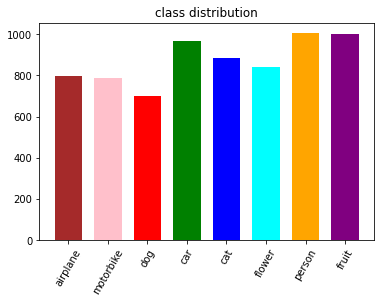

In [0]:
no_of_img_per_class=[]
for i in os.listdir(data_path):
  no_of_img_per_class.append(len(os.listdir(os.path.join(data_path,i))))
class_label=os.listdir(data_path)

plt.bar(x=class_label,height=no_of_img_per_class,width=0.7,color=['brown','pink', 'red', 'green', 'blue', 'cyan','orange','purple'])
plt.xticks(rotation=60)
plt.title("class distribution")


In [0]:
list_of_heights = []
list_of_widths = []
for i in tqdm(os.listdir(data_path)):
    for image in os.listdir(os.path.join(data_path,i)):
        img = cv2.imread(os.path.join(os.path.join(data_path,i),image), cv2.IMREAD_UNCHANGED)
        # get dimensions of image
        shape = img.shape
        list_of_heights.append(shape[0])
        list_of_widths.append(shape[1]) 

100%|██████████| 8/8 [00:17<00:00,  2.21s/it]


Text(0.5, 1.0, 'Widths')

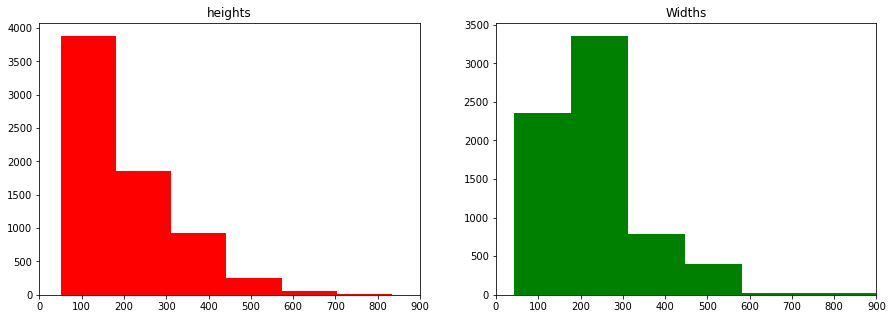

In [0]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(list_of_heights,bins=20,color='red')
plt.xlim(0,900)
plt.title('heights')
plt.subplot(1,2,2)
plt.hist(list_of_widths,bins=20,color='green')
plt.xlim(0,900)
plt.title('Widths')

In [92]:
np.mean(list_of_heights),np.mean(list_of_widths)

(197.3411107930146, 235.4931291153736)

In [10]:
datagen=ImageDataGenerator(rescale=1./255.)
INPUT_SHAPE = (224,224)
train_generator      = datagen.flow_from_directory(os.path.join(DATA_path,'train'),
                                                   shuffle=True,
                                                   batch_size=32,
                                                   target_size=INPUT_SHAPE)
validation_generator = datagen.flow_from_directory(os.path.join(DATA_path,'val'),
                                                   shuffle=True,
                                                   batch_size=32,
                                                   target_size=INPUT_SHAPE)

Found 4887 images belonging to 8 classes.
Found 1395 images belonging to 8 classes.


In [0]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(validation_generator.samples/validation_generator.batch_size)

In [0]:
class customm_callback(tf.keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.val_accuracy=[0,0]
        self.count =0
    def on_epoch_end(self,epoch,logs={}):
        self.val_accuracy.append(logs['accuracy'])

        if str(self.val_accuracy[-2])[:6] == str(self.val_accuracy[-1])[:6]:
            self.count += 1
        else :
            self.count=0

        for i  in range(len(self.model.weights)):
            try:
                a = tf.debugging.check_numerics(self.model.weights[i],'non finite weight')
            except InvalidArgument as err :
                print('\n\n\n'+' '*24,err )
                print('\n'+' '*24,"STOPPING TRAINING \n\n\n" )
                self.model.stop_training=True
                break        
            
        if  not np.isfinite(logs['loss']):
            print('\n\n\n'+' '*24,'not finite loss')
            print('\n'+' '*24,"STOPPING TRAINING \n\n\n" )
            self.model.stop_training=True
            
        if  self.count == 3:
            print('\n\n\n'+' '*24,'No improvement from last 3 epoch ')
            print('\n'+' '*24,"STOPPING TRAINING \n\n\n" )
            self.model.stop_training=True

In [73]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

conv_base_model           = tf.keras.applications.vgg16.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
conv_base_model.trainable = False
for i in conv_base_model.layers[17:]:
  i.trainable = True

Conv1                     = Conv2D(filters=256,kernel_size=(7,7),strides=(1,1),padding='valid',data_format='channels_last',
                                   activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                                   name='block6_conv1')(conv_base_model.output)

Conv2                     = Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),padding='same',data_format='channels_last',
                                    activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                                    name='block6_conv2')(Conv1)
flat                      = Flatten()(Conv2)
Out                       = Dense(units=8,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=34),name='Output')(flat)

model = Model(inputs=conv_base_model.input, outputs=Out, name='Architecture_1')
model.summary()

Model: "Architecture_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [0]:
checkpoint_path=proj_path+"model_save\model1\_{epoch:02d}_{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
callback_obj = customm_callback()

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

In [75]:
History = model.fit(train_generator,epochs=10,verbose=1,steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,validation_steps=val_steps_per_epoch,
                    callbacks=[callback_obj,checkpoint]  ).history

Epoch 1/10
153/153 [==============================] - 23s 147ms/step - loss: 4.5650 - accuracy: 0.8525 - val_loss: 0.4076 - val_accuracy: 0.9154
Epoch 2/10
153/153 [==============================] - 23s 151ms/step - loss: 0.4074 - accuracy: 0.9161 - val_loss: 0.3399 - val_accuracy: 0.9348
Epoch 3/10
153/153 [==============================] - 23s 150ms/step - loss: 0.2022 - accuracy: 0.9468 - val_loss: 0.2031 - val_accuracy: 0.9541
Epoch 4/10
153/153 [==============================] - 22s 147ms/step - loss: 0.1663 - accuracy: 0.9544 - val_loss: 0.3399 - val_accuracy: 0.9427
Epoch 5/10
153/153 [==============================] - 22s 147ms/step - loss: 0.1396 - accuracy: 0.9701 - val_loss: 0.3786 - val_accuracy: 0.9455
Epoch 6/10
153/153 [==============================] - 22s 145ms/step - loss: 0.3422 - accuracy: 0.9482 - val_loss: 0.2824 - val_accuracy: 0.9527
Epoch 7/10
153/153 [==============================] - 23s 149ms/step - loss: 0.2041 - accuracy: 0.9517 - val_loss: 0.2077 - val_ac

In [77]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

conv_base_model           = tf.keras.applications.vgg16.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
conv_base_model.trainable = False
# for i in conv_base_model.layers[17:]:
#   i.trainable = True

Conv1                     = Conv2D(filters=128,kernel_size=(7,7),strides=(1,1),padding='valid',data_format='channels_last',
                                   activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                                   name='block6_conv1')(conv_base_model.output)

Conv2                     = Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),padding='same',data_format='channels_last',
                                    activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                                    name='block6_conv2')(Conv1)
flat                      = Flatten()(Conv2)
Out                       = Dense(units=8,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=34),name='Output')(flat)

model = Model(inputs=conv_base_model.input, outputs=Out, name='Architecture_2')
model.summary()

Model: "Architecture_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [0]:
checkpoint_path=proj_path+"model_save\model2\_{epoch:02d}_{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
callback_obj = customm_callback()

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

In [81]:
History = model.fit(train_generator,epochs=10,verbose=1,steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,validation_steps=val_steps_per_epoch,
                    callbacks=[callback_obj,checkpoint]  ).history

Epoch 1/10
153/153 [==============================] - 22s 145ms/step - loss: 3.1081 - accuracy: 0.8592 - val_loss: 0.1308 - val_accuracy: 0.9577
Epoch 2/10
153/153 [==============================] - 23s 147ms/step - loss: 0.0547 - accuracy: 0.9806 - val_loss: 0.0690 - val_accuracy: 0.9828
Epoch 3/10
153/153 [==============================] - 22s 144ms/step - loss: 0.0443 - accuracy: 0.9853 - val_loss: 0.1568 - val_accuracy: 0.9663
Epoch 4/10
153/153 [==============================] - 22s 142ms/step - loss: 0.0199 - accuracy: 0.9935 - val_loss: 0.1464 - val_accuracy: 0.9577
Epoch 5/10
153/153 [==============================] - 22s 143ms/step - loss: 0.0258 - accuracy: 0.9914 - val_loss: 0.1580 - val_accuracy: 0.9706
Epoch 6/10
153/153 [==============================] - 23s 147ms/step - loss: 0.1188 - accuracy: 0.9738 - val_loss: 0.3257 - val_accuracy: 0.9505
Epoch 7/10
153/153 [==============================] - 22s 145ms/step - loss: 0.1774 - accuracy: 0.9673 - val_loss: 0.6584 - val_ac

In [6]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

conv_base_model           = tf.keras.applications.vgg16.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
conv_base_model.trainable = False



Conv1                     = Conv2D(filters=128,kernel_size=(7,7),strides=(1,1),padding='valid',data_format='channels_last',
                                   activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                                   name='block6_conv1')(conv_base_model.output)

Conv2                     = Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),padding='same',data_format='channels_last',
                                    activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                                    name='block6_conv2')(Conv1)
flat                      = Flatten()(Conv2)
Out                       = Dense(units=8,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=34),name='Output')(flat)

model = Model(inputs=conv_base_model.input, outputs=Out, name='Architecture_3')
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "Architecture_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________

In [0]:
checkpoint_path=proj_path+"/model_save/model3/_{epoch:02d}_{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
callback_obj = customm_callback()

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])


In [102]:
History = model.fit(train_generator,epochs=20,verbose=1,steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,validation_steps=val_steps_per_epoch,
                    callbacks=[callback_obj,checkpoint]  ).history

Epoch 1/20
153/153 [==============================] - 23s 148ms/step - loss: 3.0232 - accuracy: 0.8797 - val_loss: 0.1316 - val_accuracy: 0.9577
Epoch 2/20
153/153 [==============================] - 23s 150ms/step - loss: 0.0663 - accuracy: 0.9783 - val_loss: 0.0902 - val_accuracy: 0.9670
Epoch 3/20
153/153 [==============================] - 23s 147ms/step - loss: 0.0187 - accuracy: 0.9943 - val_loss: 0.0921 - val_accuracy: 0.9749
Epoch 4/20
153/153 [==============================] - 23s 148ms/step - loss: 0.0344 - accuracy: 0.9906 - val_loss: 0.2719 - val_accuracy: 0.9290
Epoch 5/20
153/153 [==============================] - 22s 145ms/step - loss: 0.0228 - accuracy: 0.9916 - val_loss: 0.0479 - val_accuracy: 0.9842
Epoch 6/20
153/153 [==============================] - 22s 145ms/step - loss: 0.0122 - accuracy: 0.9959 - val_loss: 0.1290 - val_accuracy: 0.9720
Epoch 7/20
153/153 [==============================] - 22s 145ms/step - loss: 0.0297 - accuracy: 0.9910 - val_loss: 0.3552 - val_ac

In [109]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

conv_base_model           = tf.keras.applications.vgg16.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
conv_base_model.trainable = False



Conv1                     = Conv2D(filters=1024,kernel_size=(7,7),strides=(1,1),padding='valid',data_format='channels_last',
                                   activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                                   name='block6_conv1')(conv_base_model.output)

Conv2                     = Conv2D(filters=1024,kernel_size=(1,1),strides=(1,1),padding='same',data_format='channels_last',
                                    activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                                    name='block6_conv2')(Conv1)
flat                      = Flatten()(Conv2)
Out                       = Dense(units=8,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=34),name='Output')(flat)

model = Model(inputs=conv_base_model.input, outputs=Out, name='Architecture_4')
model.summary()

Model: "Architecture_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [0]:
checkpoint_path=proj_path+"/model_save/model4/_{epoch:02d}_{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
callback_obj = customm_callback()

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])


In [112]:
History = model.fit(train_generator,epochs=50,verbose=1,steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,validation_steps=val_steps_per_epoch,
                    callbacks=[callback_obj,checkpoint]  ).history

Epoch 1/50
153/153 [==============================] - 25s 166ms/step - loss: 12.5683 - accuracy: 0.8613 - val_loss: 0.1892 - val_accuracy: 0.9606
Epoch 2/50
153/153 [==============================] - 24s 155ms/step - loss: 0.3028 - accuracy: 0.9321 - val_loss: 0.5845 - val_accuracy: 0.8731
Epoch 3/50
153/153 [==============================] - 24s 159ms/step - loss: 0.1909 - accuracy: 0.9601 - val_loss: 0.1852 - val_accuracy: 0.9656
Epoch 4/50
153/153 [==============================] - 24s 155ms/step - loss: 0.1138 - accuracy: 0.9767 - val_loss: 0.2365 - val_accuracy: 0.9462
Epoch 5/50
153/153 [==============================] - 24s 157ms/step - loss: 0.2289 - accuracy: 0.9718 - val_loss: 0.1581 - val_accuracy: 0.9735
Epoch 6/50
153/153 [==============================] - 23s 151ms/step - loss: 0.3112 - accuracy: 0.9310 - val_loss: 0.2359 - val_accuracy: 0.9556
Epoch 7/50
153/153 [==============================] - 22s 147ms/step - loss: 0.3665 - accuracy: 0.9104 - val_loss: 0.4002 - val_a

In [121]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

conv_base_model           = tf.keras.applications.vgg16.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
conv_base_model.trainable = False



Conv1                     = Conv2D(filters=128,kernel_size=(7,7),strides=(1,1),padding='valid',data_format='channels_last',
                                   activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                                   name='block6_conv1')(conv_base_model.output)

Conv2                     = Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),padding='same',data_format='channels_last',
                                    activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                                    name='block6_conv2')(Conv1)
flat                      = Flatten()(Conv2)
Out                       = Dense(units=8,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(seed=34),name='Output')(flat)

model = Model(inputs=conv_base_model.input, outputs=Out, name='Architecture_5')
model.summary()

Model: "Architecture_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [0]:
checkpoint_path=proj_path+"/model_save/model5/_{epoch:02d}_{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
callback_obj = customm_callback()

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])


In [120]:
History = model.fit(train_generator,epochs=50,verbose=1,steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,validation_steps=val_steps_per_epoch,
                    callbacks=[callback_obj,checkpoint]  ).history

Epoch 1/50
153/153 [==============================] - 21s 139ms/step - loss: 1.9089 - accuracy: 0.8838 - val_loss: 0.3412 - val_accuracy: 0.9147
Epoch 2/50
153/153 [==============================] - 21s 140ms/step - loss: 0.0783 - accuracy: 0.9767 - val_loss: 0.1324 - val_accuracy: 0.9656
Epoch 3/50
153/153 [==============================] - 22s 143ms/step - loss: 0.0646 - accuracy: 0.9818 - val_loss: 0.0986 - val_accuracy: 0.9756
Epoch 4/50
153/153 [==============================] - 21s 137ms/step - loss: 0.0393 - accuracy: 0.9877 - val_loss: 0.3004 - val_accuracy: 0.9491
Epoch 5/50
153/153 [==============================] - 21s 137ms/step - loss: 0.1123 - accuracy: 0.9754 - val_loss: 0.0966 - val_accuracy: 0.9756
Epoch 6/50
153/153 [==============================] - 21s 136ms/step - loss: 0.1650 - accuracy: 0.9707 - val_loss: 0.3071 - val_accuracy: 0.9441
Epoch 7/50
153/153 [==============================] - 21s 137ms/step - loss: 0.2314 - accuracy: 0.9683 - val_loss: 0.4727 - val_ac

# Best Architecture

In [0]:
val_score=[]
Architectures=['Architecture_1','Architecture_2','Architecture_3','Architecture_4','Architecture_5']
for i in os.listdir(os.path.join(proj_path,'model_save')):
  temp=0
  for j in os.listdir(os.path.join(os.path.join(proj_path,'model_save'),i)):
    a=float(j.split('.')[-2])/10000
    temp = a if a>temp else temp
  val_score.append(temp) 

In [0]:
val_score=[0.9577,0.9828,0.9871,0.9857,0.9828]
Architectures=['Architecture_1','Architecture_2','Architecture_3','Architecture_4','Architecture_5']

Text(0, 0.5, 'Validation Score')

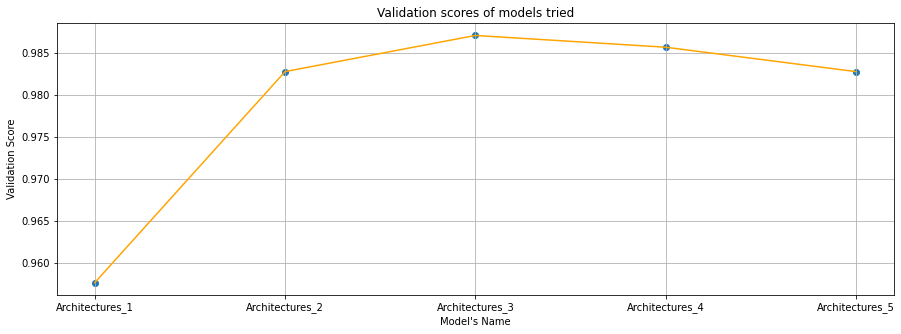

In [132]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(Architectures,val_score,color='orange')
plt.scatter(Architectures,val_score)
plt.title("Validation scores of models tried")
plt.xlabel("Model's Name")
plt.ylabel("Validation Score")

# Loading & testing best Model


In [0]:
# run architecture 3 first
model.load_weights(os.path.join(os.path.join(os.path.join(proj_path,'model_save'),'model3'),'_01_0.9871.hdf5'))

In [11]:
test_generator = datagen.flow_from_directory(os.path.join(DATA_path,'test'),
                                                   shuffle=False,
                                                   batch_size=704,
                                                   target_size=INPUT_SHAPE)

Found 704 images belonging to 8 classes.


In [0]:
a = model.predict(test_generator.next())

In [0]:
y_pred=[]
for i in a:
  y_pred.append(np.argmax(i))
y_true=test_generator.classes

In [0]:
conf_mat = confusion_matrix(y_true, y_pred)

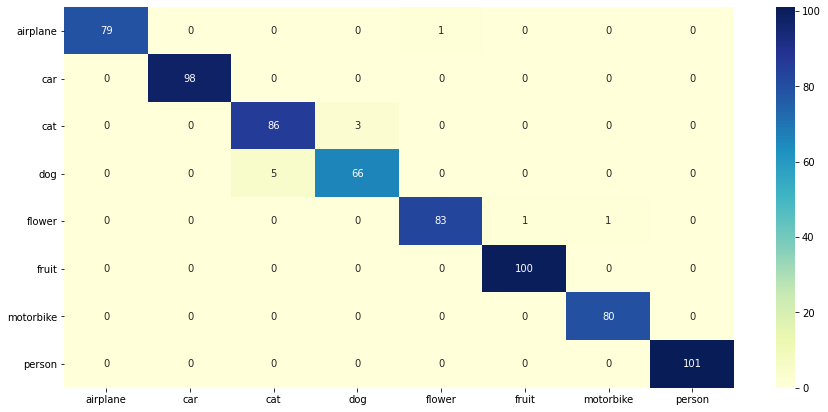

In [34]:
plt.figure(figsize=(15,7))
sns.heatmap(conf_mat, annot=True, fmt="d",cmap="YlGnBu",xticklabels=test_generator.class_indices.keys(),yticklabels=test_generator.class_indices.keys())